
# Churn model development

### Table of Contents

1. [Dependencies](#Dependencies)
2. [Data cleaning](#Datacleaning)
3. [Pre-processing](#Pre-processing)
4. [Model selection](#Modelselection)
5. [Fit models](#fitmodels)
6. [Model validation](#modelvalidation)
7. [Retention assessment](#Retentionassessment) 

### 1. Dependencies <a class="anchor" id="Dependencies"></a>

In [1]:
# Import dependencies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model and data processing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler, MinMaxScaler

# Model and pipeline build

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model validation
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, plot_confusion_matrix,
                             classification_report, make_scorer, plot_roc_curve, plot_precision_recall_curve)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer

# save model
import joblib



### 2. Data cleaning <a class="anchor" id="Datacleaning"></a>

Read in data

In [2]:
# Read in data
df =pd.read_csv('../01 Data/churn_challenge.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Look at the data types

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Convert the TotalCharges column to a numeric data type

### 3. Pre-processing <a class="anchor" id="Pre-processing"></a>

In [5]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors = 'coerce')
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [6]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
df.shape

(7043, 21)

There are only 11 out 7043 rows which contain nulls, we will delete them

In [8]:
df.dropna(inplace = True)
# Remove customer IDs from the data set
df2 = df.iloc[:,1:]

Convert the predictor variable in to a binary numeric variable

In [9]:
df2['Churn'].replace(to_replace=['Yes', 'No'] ,value = [1, 0], inplace=True)
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Convert all categorical variables into dummy variables

In [10]:
#Convert all categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


split into X_train and y_train

In [11]:
# split into x_train and x_val
X_train = df_dummies.drop(['Churn'], axis=1)
y_train = df_dummies['Churn']

Churn is imbalanced so need to stratify

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=.30)

Scale numeric fields to be between 0 and 1

In [13]:
# Create a min max scaler
mms = MinMaxScaler()
#fit scaler to train
X_train = pd.DataFrame(mms.fit(X_train).transform(X_train), columns = X_train.columns)

# fit scaler to validation set
X_val = pd.DataFrame(mms.fit(X_val).transform(X_val), columns = X_train.columns)

For model selection use stratified Kfold test and constant seed to allow repeatable results

In [14]:
n_folds = 10
seed = 3
kfold = StratifiedKFold(n_splits=n_folds, random_state=seed, shuffle=True)

### 4. Model selection <a class="anchor" id="Modelselection"></a>

Build list of models to run

In [15]:
clf_mdls = []

clf_mdls.append(("Logistic Regression", LogisticRegression(penalty = 'l2', class_weight = 'balanced')))

clf_mdls.append(("Naive Bayes", GaussianNB()))

clf_mdls.append(("Decision Trees", DecisionTreeClassifier()))

clf_mdls.append(("Random Forest", RandomForestClassifier()))

clf_mdls.append(("XGBoost", XGBClassifier()))

### 5. Fit models <a class="anchor" id="fitmodels"></a>

Fit and score the models using f1 score

For customer churn we are concerned with the number of true positives (TP)

False positives (FP) indicate customers we thought would churn but didnt

False negatives (FN) indicate customers we failed to identify as churning and represent missed opportunity to re-engage

Precision considers the ratio TP / (TP + FP)

Recall considers the ratio TP / (TP + FN)

The F1 score is 2 * (Precision * Recall) / (Precision + Recall)

AUC is not an appropriate metric for an imbalanced classifier


In [16]:
dff1 = pd.DataFrame(columns = ['model', 'f1'], index = None)
df_temp = pd.DataFrame(columns = ['model', 'f1'], index = None)
results, names  = [], []
score = 'f1'

# Fit each model using k-fold validation and store results in dataframe
for name, model  in clf_mdls:
    # get cross validation results
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=score, n_jobs=-1)
    
    
    # store results in temporary dataframe
    df_temp = pd.DataFrame([[score, name] for score in cv_results],
                           columns = ['f1', 'model'])
    
    # Update dff1 with temporary dataframe results
    dff1 = pd.concat([dff1, df_temp], ignore_index = True)   
    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)

Logistic Regression: 0.626192 (+/- 0.015016)
Naive Bayes: 0.595065 (+/- 0.020127)
Decision Trees: 0.498236 (+/- 0.036009)
Random Forest: 0.540268 (+/- 0.034804)
XGBoost: 0.541011 (+/- 0.026568)


In [17]:
dff1.head()

,model,f1
0,Logistic Regression,0.598765
1,Logistic Regression,0.637168
2,Logistic Regression,0.636364
3,Logistic Regression,0.629412
4,Logistic Regression,0.611276


Select the most appropriate model to move forward with based on the cross validated f1 score

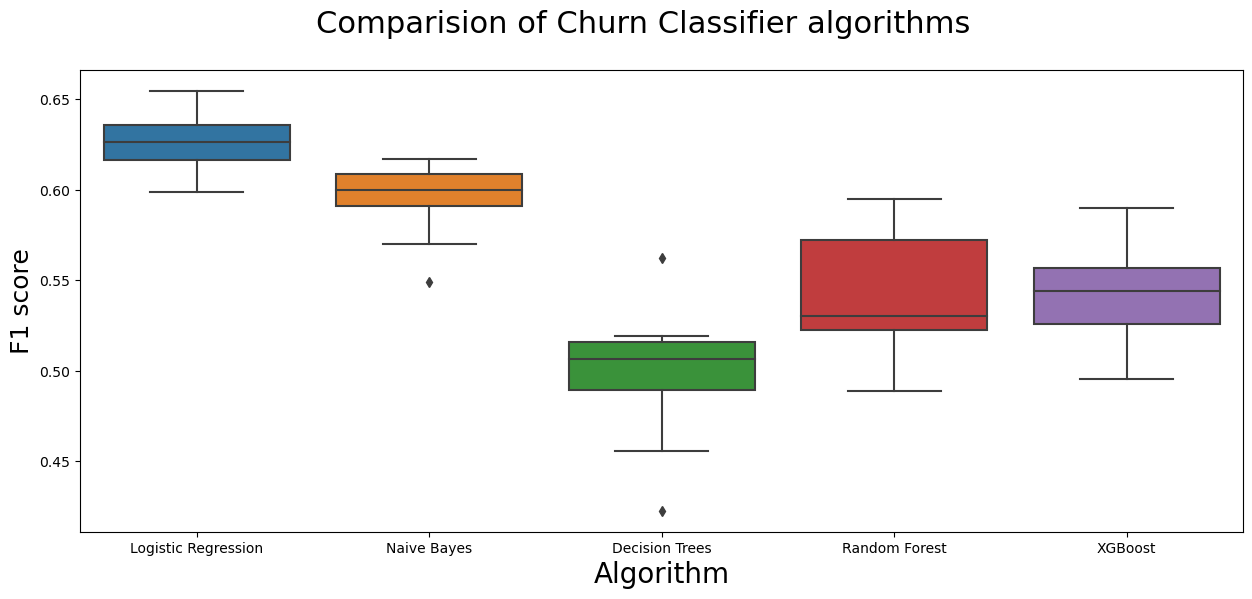

In [18]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Comparision of Churn Classifier algorithms', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x='model', y='f1', data=dff1)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithm", fontsize=20)
ax.set_ylabel("F1 score", fontsize=18)
ax.set_xticklabels(dff1['model'].unique().tolist())
plt.savefig('../04 Output/modelselection.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show()

### 5. Model validation <a class="anchor" id="modelvalidation"></a>

Using the cross-validated f1 score we take the logistic regression model to validation

In [19]:
# Create logistic regression model
logreg = LogisticRegression(penalty = 'l2', class_weight = 'balanced')

Fit the model to X and y training data

In [20]:
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

Make predictions in training and validation data sets

In [21]:
y_hat_train = logreg.predict(X_train)
y_hat_val = logreg.predict(X_val)

Print the classification report for the training data

In [22]:
target_names = ['Not churn', 'Churn']
print(classification_report(y_train,y_hat_train, target_names=target_names))

              precision    recall  f1-score   support

   Not churn       0.91      0.73      0.81      3614
       Churn       0.52      0.81      0.63      1308

    accuracy                           0.75      4922
   macro avg       0.72      0.77      0.72      4922
weighted avg       0.81      0.75      0.76      4922



Print the classification report for the validation data

In [23]:
print(classification_report(y_val,y_hat_val, target_names=target_names))

              precision    recall  f1-score   support

   Not churn       0.91      0.73      0.81      1549
       Churn       0.51      0.80      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110



Plot the confusion matrix for training

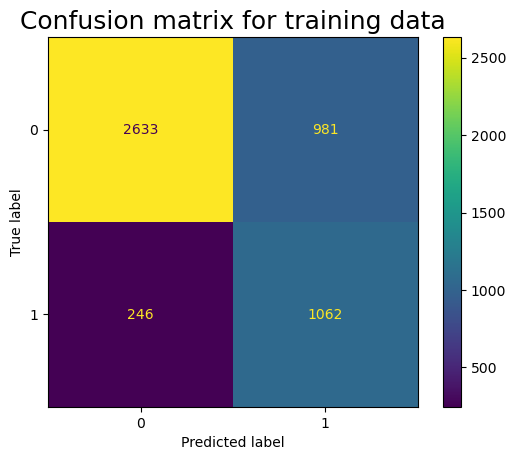

In [24]:
cm = plot_confusion_matrix(logreg, X_train, y_train)
cm.ax_.set_title('Confusion matrix for training data',fontsize = 18 )
plt.savefig('../04 Output/cnfsnmtrxtrain.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show() 

Plot the confusion matrix for validation

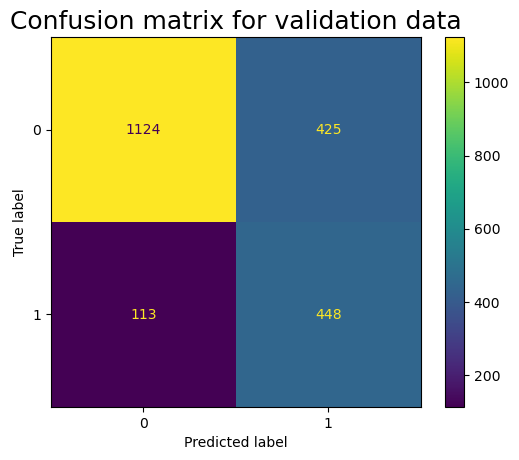

In [25]:
# plot confusion matrix for validation
cm = plot_confusion_matrix(logreg, X_val, y_val)
cm.ax_.set_title('Confusion matrix for validation data',fontsize = 18 )
plt.savefig('../04 Output/cnfsnmtrxval.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show() 

Plot the roc curve for training

Note this is not as important as the precision and recall curve for imbalanced data

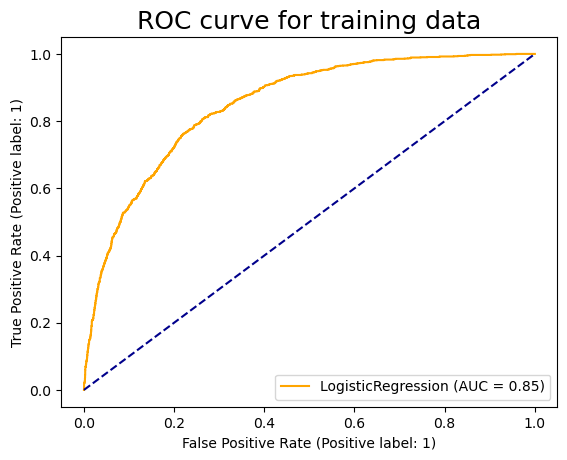

In [26]:
rc = plot_roc_curve(logreg, X_train, y_train, color='orange')
rc.ax_.set_title('ROC curve for training data',fontsize = 18 )
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.savefig('../04 Output/roccrvetrain.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show() 

Plot the roc curve for validation

Note this is not as important as the precision and recall curve for imbalanced data

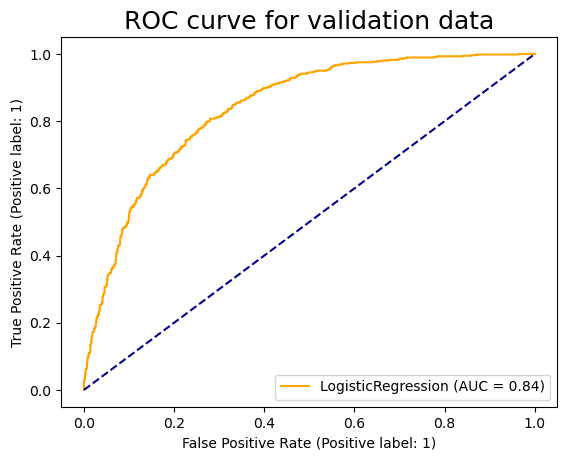

In [27]:
rc = plot_roc_curve(logreg, X_val, y_val, color='orange')
rc.ax_.set_title('ROC curve for validation data',fontsize = 18 )
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.savefig('../04 Output/roccrveval.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show() 

Plot the precision and recall curve for training

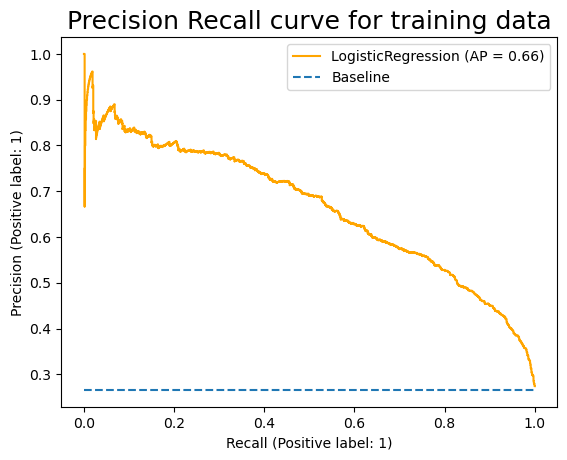

In [28]:
pr = plot_precision_recall_curve(logreg, X_train, y_train, color='orange')
pr.ax_.set_title('Precision Recall curve for training data',fontsize = 18 )
baseline = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.legend(loc = 'best')
plt.savefig('../04 Output/prcsnrclltrain.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show()

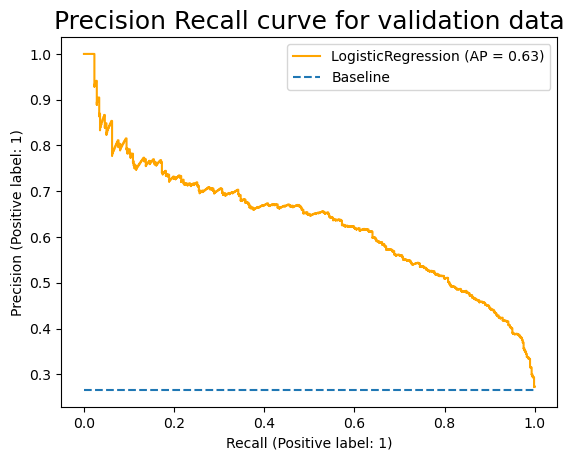

In [29]:
pr = plot_precision_recall_curve(logreg, X_val, y_val, color='orange')
pr.ax_.set_title('Precision Recall curve for validation data',fontsize = 18 )
baseline = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.legend(loc = 'best')
plt.savefig('../04 Output/prcsnrcllval.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show()

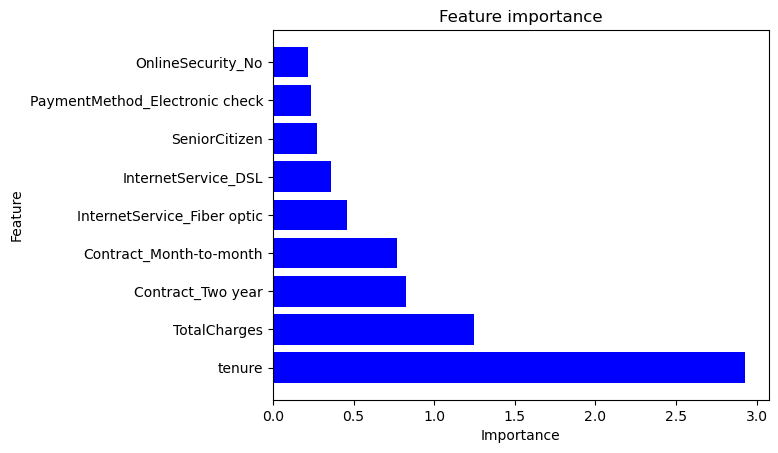

In [30]:
# get importance
importance = pd.DataFrame(abs(logreg.coef_[0]))
# create data frame with importance
d = {'importance':abs(logreg.coef_[0]),'label':X_train.columns}
df_imp = pd.DataFrame(d)
# sort by importance
df_imp.sort_values('importance', axis = 0, ascending = False, inplace = True)
# select top 10 features
imp_df = df_imp[0:9].copy()

plt.barh(y = 'label', width = 'importance', data = imp_df, color='blue')
plt.title("Feature importance")    
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig('../04 Output/ftrimprtnc.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

plt.show()

### 6. Retention assessment <a class="anchor" id="Retentionassessment"></a>

The modeled probability a given customer will churn can be segmented into risk categories

These categories can be used to develop retention strategies




Using training data create DataFrame using the probability a customer will churn 

In [31]:
d = {'Churn_prob':logreg.predict_proba(X_train)[:,1], 'Churned': y_train}
df_train = pd.DataFrame(d)
df_train['Churned'] = df_train['Churned'].replace([0,1],['No', 'Yes'])

# create bins
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]


# create labels to assign to each bin
labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

# create a new column and use bins to assign risk
df_train['Churnrisk'] = pd.cut(df_train['Churn_prob'], bins, labels=labels)

# display updated DataFrame
df_train.head()

,Churn_prob,Churned,Churnrisk
4362,0.039950,No,Very low
6433,0.009953,No,Very low
6439,0.611122,No,High
6875,0.009621,No,Very low
6896,0.570274,Yes,Medium


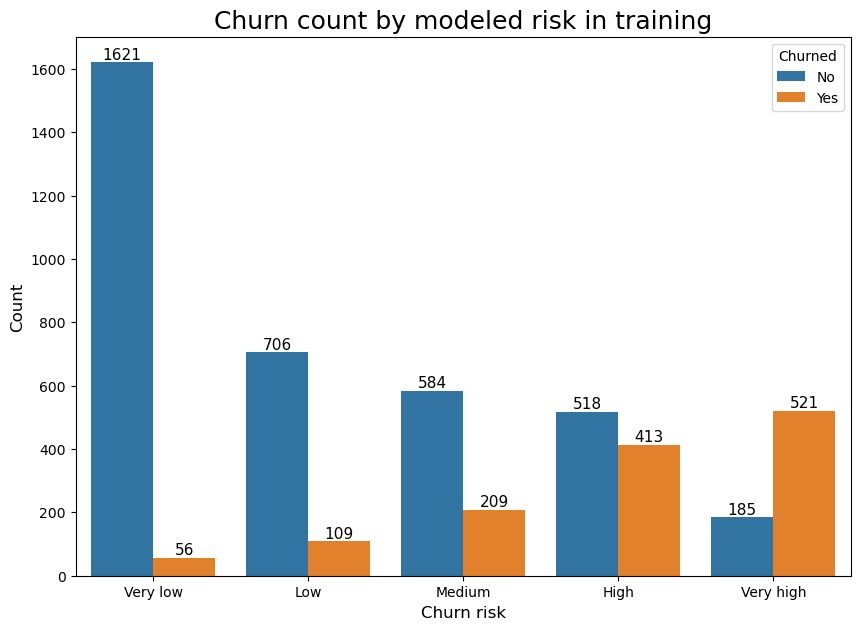

In [32]:
label_order = ['Very low', 'Low', 'Medium', 'High', 'Very high']
plt.subplots(figsize = (10,7))
ax = sns.countplot(x="Churnrisk", hue='Churned', data=df_train, order = label_order)
ax.set_title('Churn count by modeled risk in training',fontsize = 18)
ax.set_xlabel('Churn risk', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2, rect.get_height()+ 10, rect.get_height()
             ,horizontalalignment='center', fontsize = 11)
plt.savefig('../04 Output/chrncntrsktrain.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)    
plt.show()

Using validation data create DataFrame using the probability a customer will churn 

In [33]:
d = {'Churn_prob':logreg.predict_proba(X_val)[:,1], 'Churned': y_val}
df_val = pd.DataFrame(d)
df_val['Churned'] = df_val['Churned'].replace([0,1],['No', 'Yes'])

# create bins
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]


# create labels to assign to each bin
labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

# create a new column and use bins to assign risk
df_val['Churnrisk'] = pd.cut(df_val['Churn_prob'], bins, labels=labels)

# display updated DataFrame
df_val.head()

,Churn_prob,Churned,Churnrisk
3915,0.184919,No,Very low
5320,0.029745,No,Very low
3157,0.509398,Yes,Medium
2205,0.680430,No,High
5531,0.067053,No,Very low


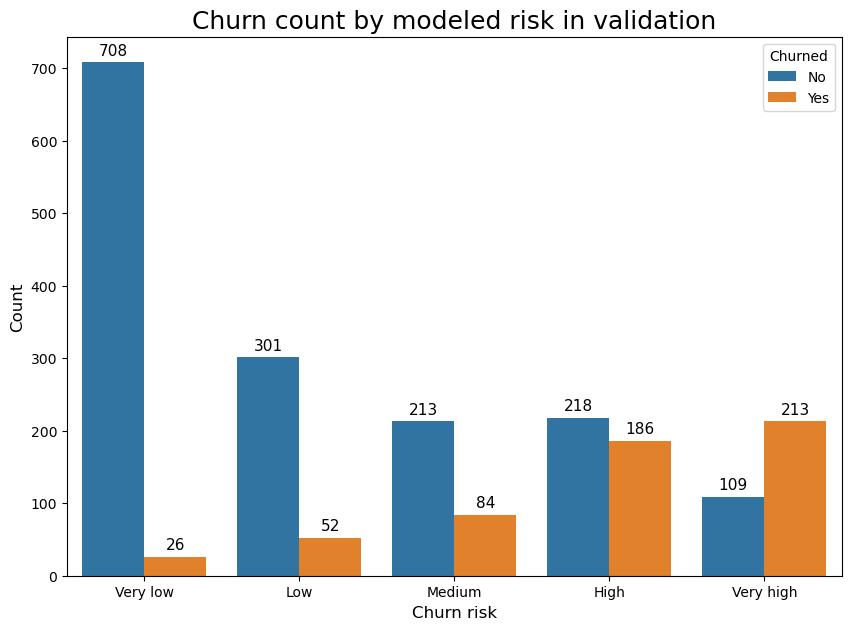

In [34]:
label_order = ['Very low', 'Low', 'Medium', 'High', 'Very high']
plt.subplots(figsize = (10,7))
ax = sns.countplot(x="Churnrisk", hue='Churned', data=df_val, order = label_order)
ax.set_title('Churn count by modeled risk in validation',fontsize = 18)
ax.set_xlabel('Churn risk', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2, rect.get_height()+ 10, rect.get_height()
             ,horizontalalignment='center', fontsize = 11)
plt.savefig('../04 Output/chrncntrskval.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)       
plt.show()